In [1]:
import sys, glob, os
import h5py
import numba

sys.path.append(os.path.expanduser("~")+'/uvpy/')
import uvfunctions as uvf
import uvplot as uvp
import uvtests as uvt

sys.path.append(os.path.expanduser("~")+'/CEUAS/CEUAS/public/cds-backend/code/')
import cds_eua4 as eua

import matplotlib
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt
matplotlib.rcParams.update({'font.size': 20})
plt.rcParams['lines.linewidth'] = 3


import numpy as np
import pandas as pd

import ray
ray.init(num_cpus=80)

no config found


2023-08-14 09:12:16,132	INFO worker.py:1528 -- Started a local Ray instance.


RayContext(dashboard_url='', python_version='3.10.6', ray_version='2.1.0', ray_commit='be49bde7ee4f6adb3f8710aee0665c27f9f0bb62', address_info={'node_ip_address': '131.130.157.5', 'raylet_ip_address': '131.130.157.5', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2023-08-14_09-12-07_584544_1523755/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2023-08-14_09-12-07_584544_1523755/sockets/raylet', 'webui_url': '', 'session_dir': '/tmp/ray/session_2023-08-14_09-12-07_584544_1523755', 'metrics_export_port': 64112, 'gcs_address': '131.130.157.5:57799', 'address': '131.130.157.5:57799', 'dashboard_agent_listen_port': 52365, 'node_id': '09b45cfe792b5ae8f84ca17517b4d56e7e7fba7c5a54b112f7614440'})

In [2]:
@numba.jit(nopython=True)
def sel_platform_type(ts, pt, start, end):
    out = np.unique(pt[np.logical_and(ts >= start, ts <= end)])
    if len(out) == 0:
        return 999
    elif len(out) != 1:
        return 100
    else:
        return int(out[0])

@ray.remote    
def find_platform_type(f, start, end):
    try:
        with h5py.File(f) as file:
            pt = np.array(file['header_table']['platform_type'][:])
            ts = np.array(file['header_table']['record_timestamp'][:])
            lat = file['header_table']['latitude'][-1]
            lon = file['header_table']['longitude'][-1]
        return [f, sel_platform_type(ts, pt, start, end), float(lat), float(lon)]
    except:
        print(f)
        return [f,0,0,0]

In [3]:
def plot_platform_type(year):
    
    sd = year + '-07-01'
    ed = year + '-07-31'
    start = uvf.datetime_to_seconds(np.datetime64(sd))
    end = uvf.datetime_to_seconds(np.datetime64(ed))
    files = glob.glob('/mnt/users/scratch/leo/scratch/converted_v13/long/*.nc')

    result_ids = []
    for i in files[:]:
        result_ids.append(find_platform_type.remote(i, start, end))

    results = ray.get(result_ids)

    rdf = pd.DataFrame.from_dict({'platform_type': list(np.array(results)[:, 1].astype(int)), 'lat': list(np.array(results)[:, 2].astype(float)), 'lon': list(np.array(results)[:, 3].astype(float)), 'name': list(np.array(results)[:, 0])})
    rdf_cleaned = rdf[rdf.platform_type != 999]

    color_continuous_scale=[(0.00, "red"),   (0.50, "red"),
                            (0.50, "blue"),  (1.00, "blue")]
    img = uvp.world_map_plot(data = rdf_cleaned.platform_type, lat_list=rdf_cleaned.lat, lon_list=rdf_cleaned.lon, lable_list=rdf_cleaned.name, title=year + ' platform_type', marker_size = 10, cs=color_continuous_scale, show=False)
    img.write_image('new_world_map_plot_platform_type_'+sd+'.png')


In [9]:
with h5py.File('/mnt/users/scratch/leo/scratch/converted_v13/long/0-20700-0-89571_CEUAS_merged_v1.nc') as file:
    for i in file['header_table'].keys():
        print(i, len(file['header_table'][i]))

application_area 0
crs 0
duplicate_status 0
duplicates 0
events_at_station 0
height_of_station_above_local_ground 0
height_of_station_above_sea_level 0
height_of_station_above_sea_level_accuracy 0
index 0
instrument 0
latitude 0
location_accuracy 0
location_method 0
location_quality 0
longitude 0
number_of_pressure_levels 0
observing_programme 0
owner 0
platform_sub_type 0
platform_type 0
primary_station_id 0
primary_station_id_scheme 0
processing_codes 0
processing_level 0
product_name 0
product_version 0
profile_id 0
record_timestamp 0
references 0
region 0
report_duration 0
report_id 0
report_meaning_of_timestamp 0
report_quality 0
report_synoptic_time 0
report_time_accuracy 0
report_time_quality 0
report_time_reference 0
report_timestamp 0
report_type 0
sea_level_datum 0
source_id 0
source_record_id 0
station_course 0
station_heading 0
station_name 0
station_record_number 0
station_speed 0
station_type 0
string15 15
string20 20
string21 20
string25 20
string6 6
sub_region 0


2023-07-13 13:32:22,341	ERROR worker.py:400 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::find_platform_type() (pid=640266, ip=131.130.157.5)
  File "/tmp/ipykernel_639465/3573824814.py", line 16, in find_platform_type
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "/users/staff/uvoggenberger/.conda/envs/uvn10/lib/python3.10/site-packages/h5py/_hl/dataset.py", line 758, in __getitem__
    return self._fast_reader.read(args)
  File "h5py/_selector.pyx", line 361, in h5py._selector.Reader.read
  File "h5py/_selector.pyx", line 151, in h5py._selector.Selector.apply_args
IndexError: Index (-1) out of range for empty dimension
2023-07-13 13:32:22,343	ERROR worker.py:400 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::find_platform_type() (pid=640285, ip=131.130.157.5)
  File "/tmp/ipykernel_639465/3573824814.py", line 16, in find_platfor

In [4]:
plot_platform_type(year = '1950')
plot_platform_type(year = '1980')
plot_platform_type(year = '2010')


*** SIGTERM received at time=1692175387 on cpu 72 ***
PC: @     0x7f952f94eabe  (unknown)  epoll_wait
    @     0x7f952f854df0  (unknown)  (unknown)
[2023-08-16 10:43:07,574 E 1523755 1523755] logging.cc:361: *** SIGTERM received at time=1692175387 on cpu 72 ***
[2023-08-16 10:43:07,574 E 1523755 1523755] logging.cc:361: PC: @     0x7f952f94eabe  (unknown)  epoll_wait
[2023-08-16 10:43:07,574 E 1523755 1523755] logging.cc:361:     @     0x7f952f854df0  (unknown)  (unknown)


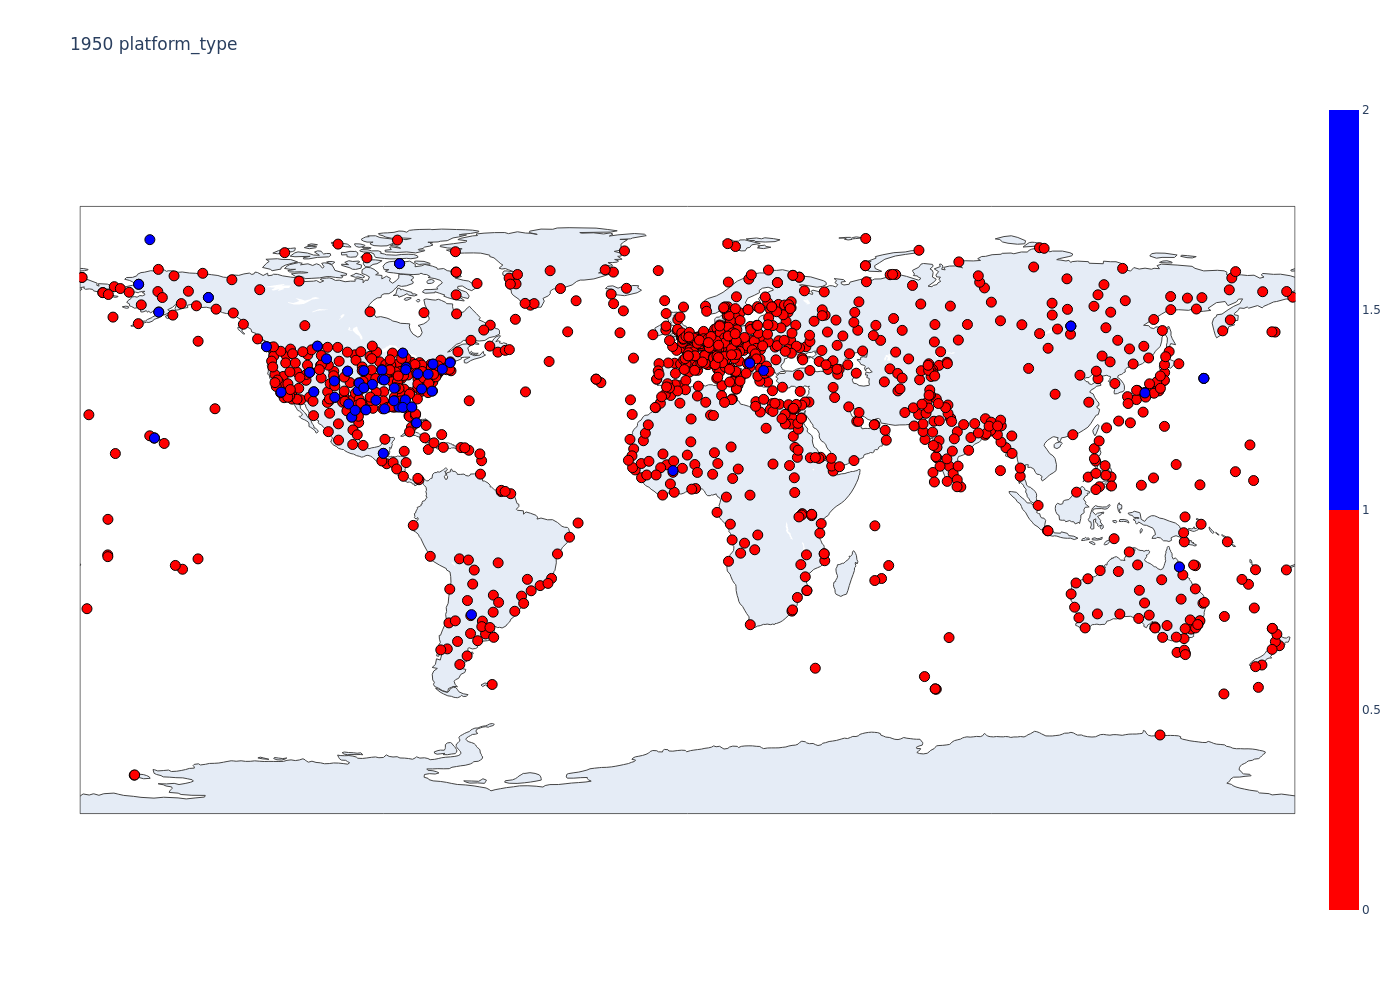

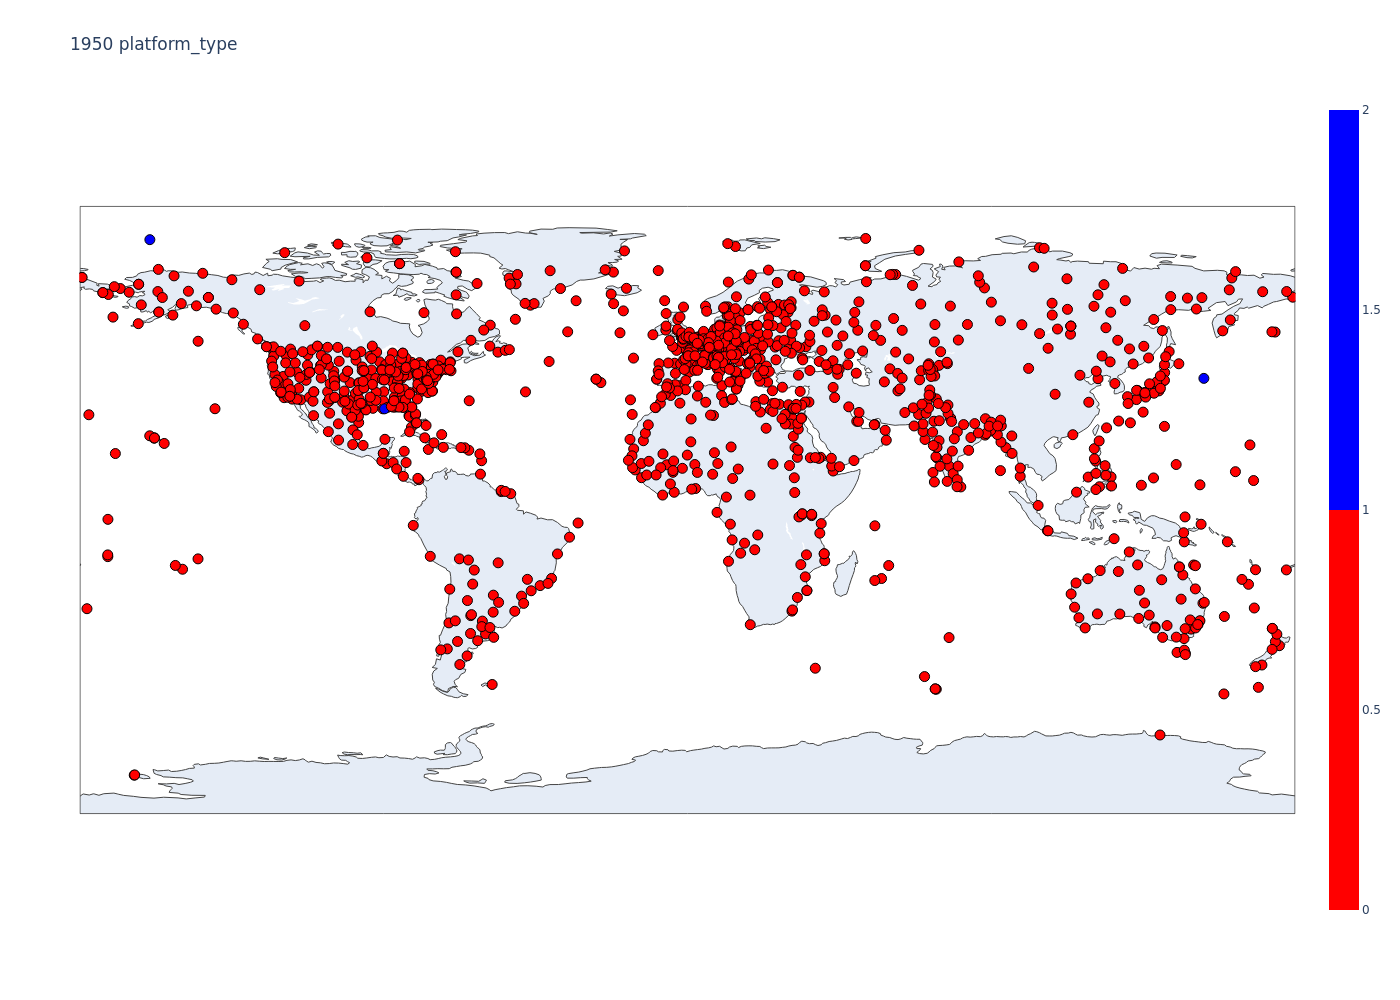

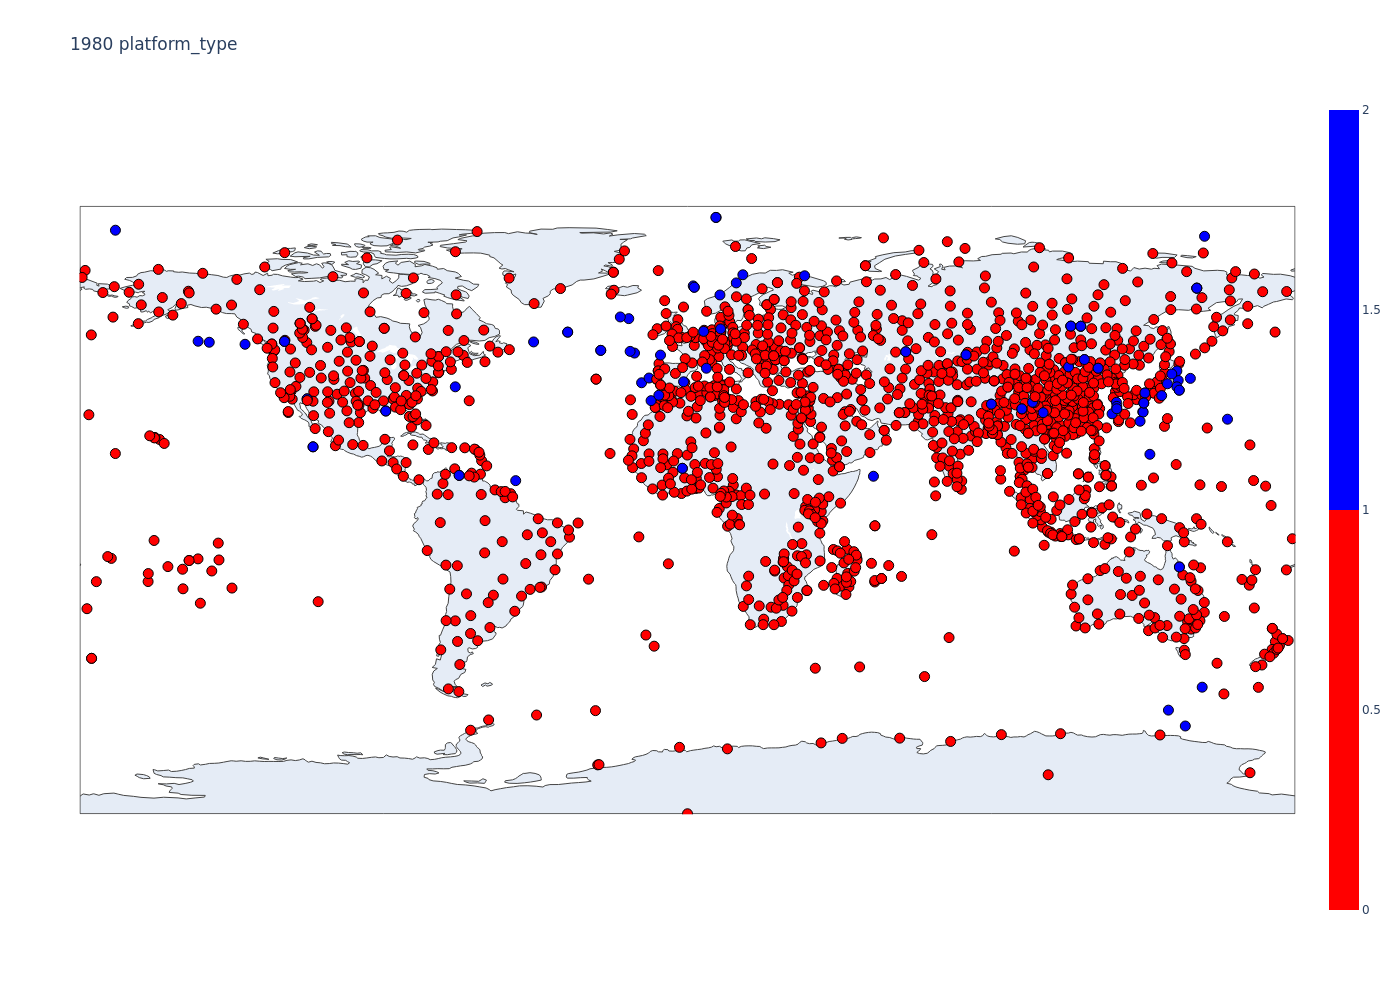

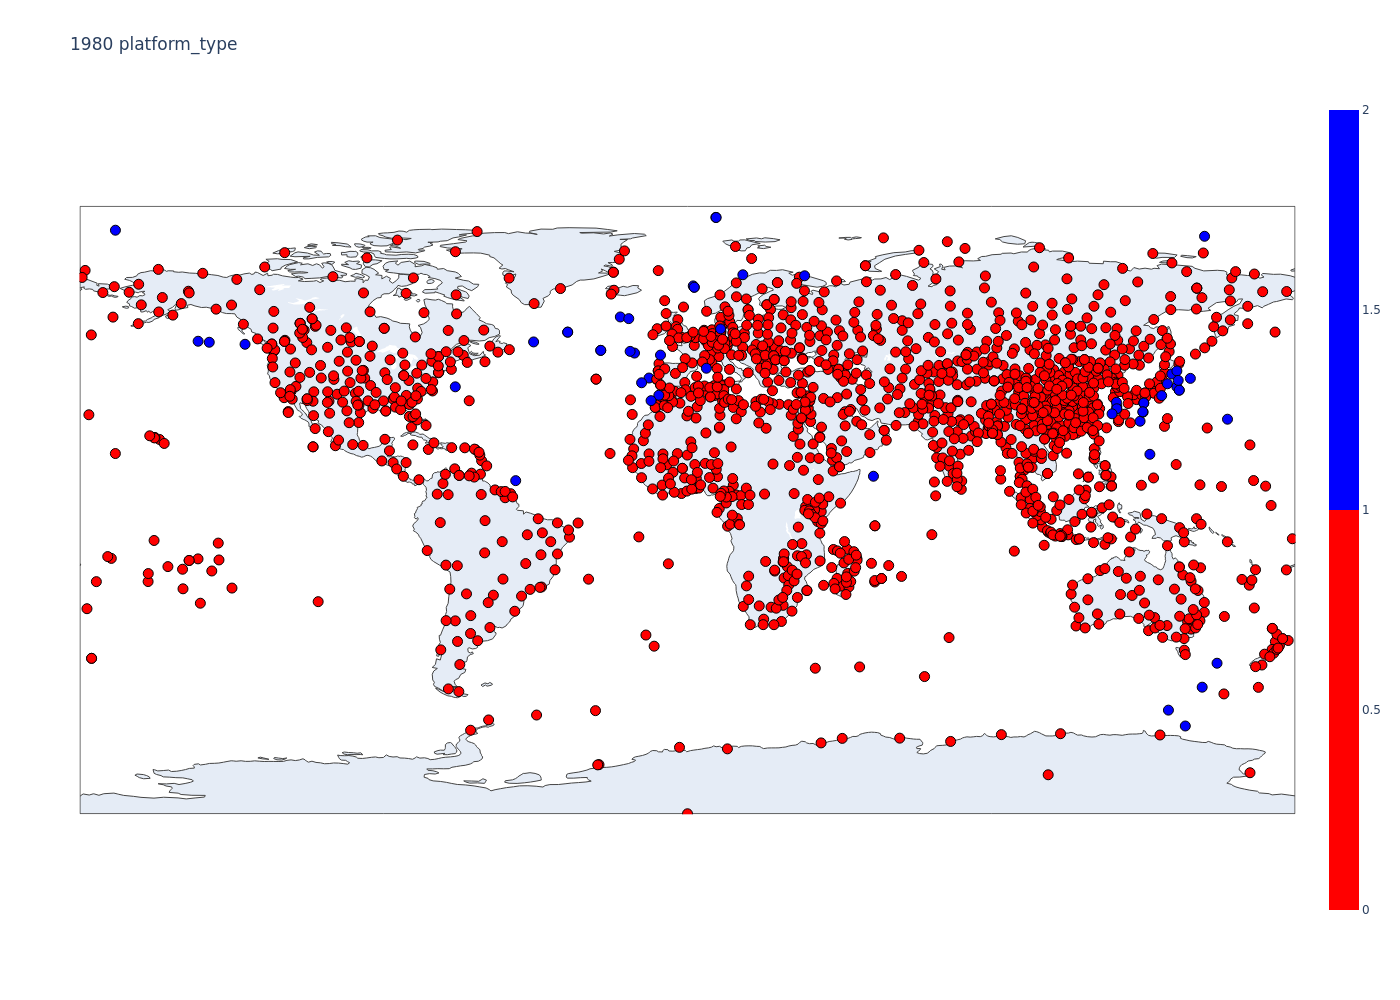

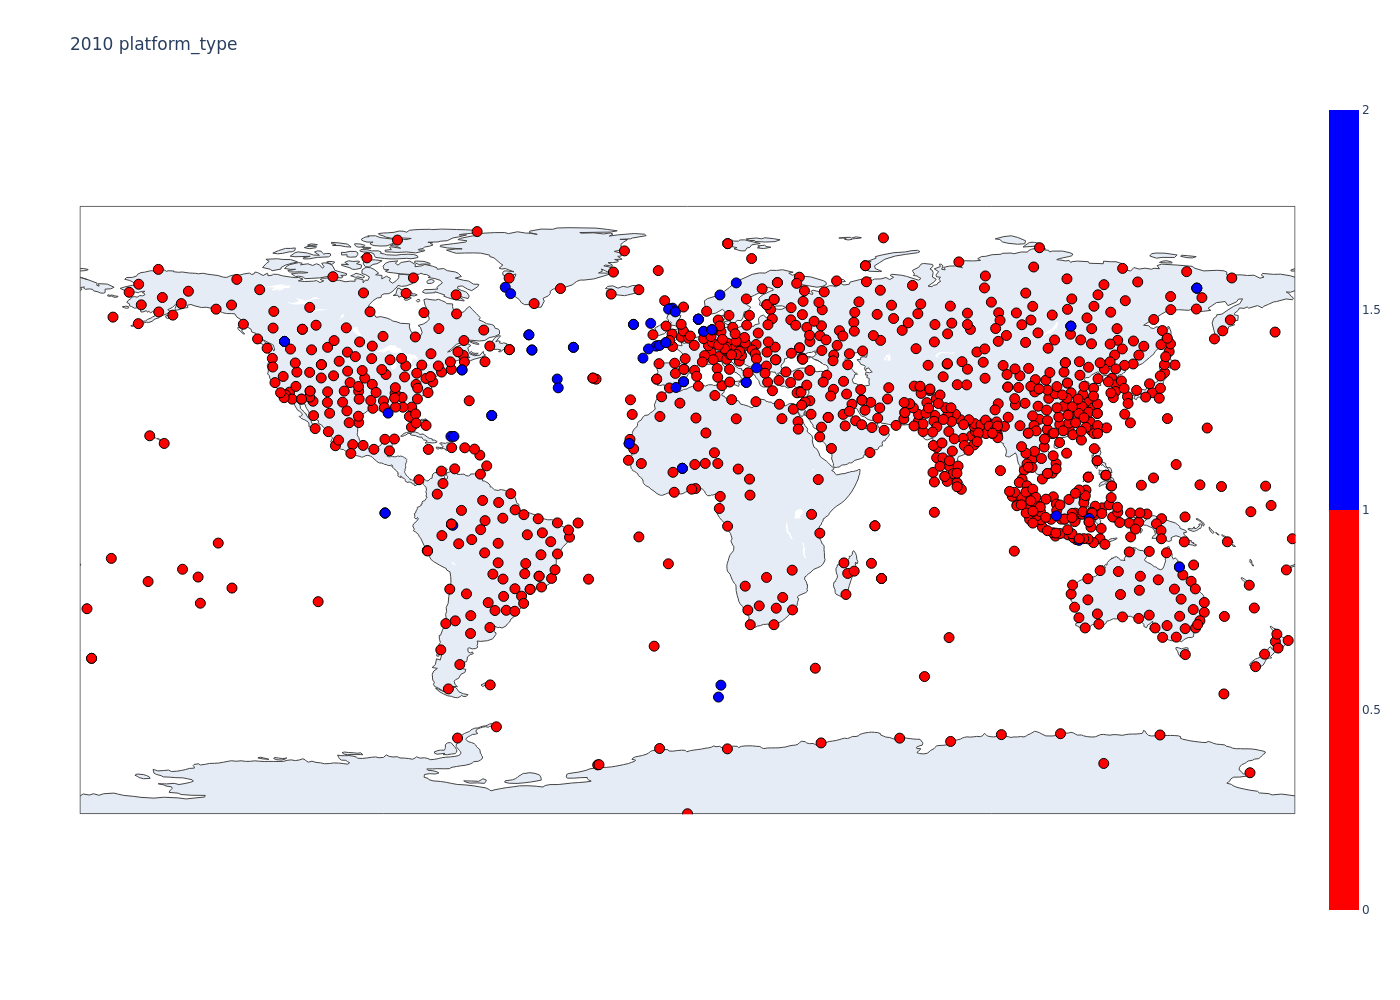

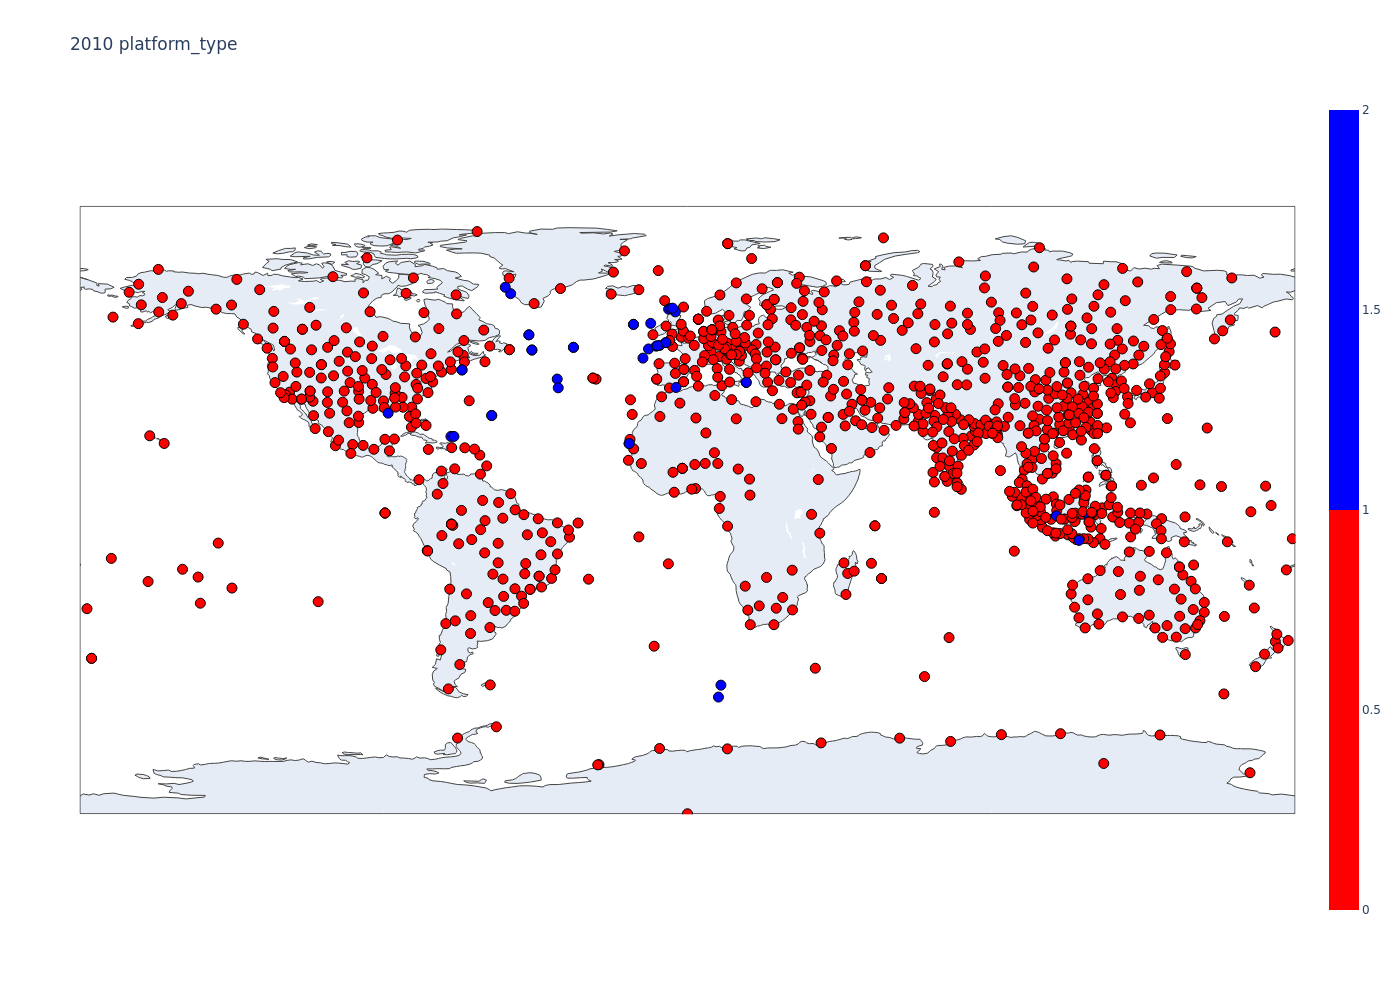

(raylet) [2023-07-14 16:46:05,694 E 778700 778794] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-07-13_16-06-21_361660_778392 is over 95% full, available space: 199847936; capacity: 75125227520. Object creation will fail if spilling is required.
(raylet) [2023-07-14 16:46:15,699 E 778700 778794] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-07-13_16-06-21_361660_778392 is over 95% full, available space: 24346624; capacity: 75125227520. Object creation will fail if spilling is required.
(raylet) [2023-07-14 16:46:25,705 E 778700 778794] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-07-13_16-06-21_361660_778392 is over 95% full, available space: 40144896; capacity: 75125227520. Object creation will fail if spilling is required.
(raylet) [2023-07-14 16:46:35,709 E 778700 778794] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-07-13_16-06-21_361660_778392 is over 95% full, available space: 36864; capacity: 75125227520. Object creation will 

In [6]:
from IPython.display import Image
display(Image(filename='./world_map_plot_platform_type_1950-07-01.png'))
display(Image(filename='./new_world_map_plot_platform_type_1950-07-01.png'))
display(Image(filename='./world_map_plot_platform_type_1980-07-01.png'))
display(Image(filename='./new_world_map_plot_platform_type_1980-07-01.png'))
display(Image(filename='./world_map_plot_platform_type_2010-07-01.png'))
display(Image(filename='./new_world_map_plot_platform_type_2010-07-01.png'))

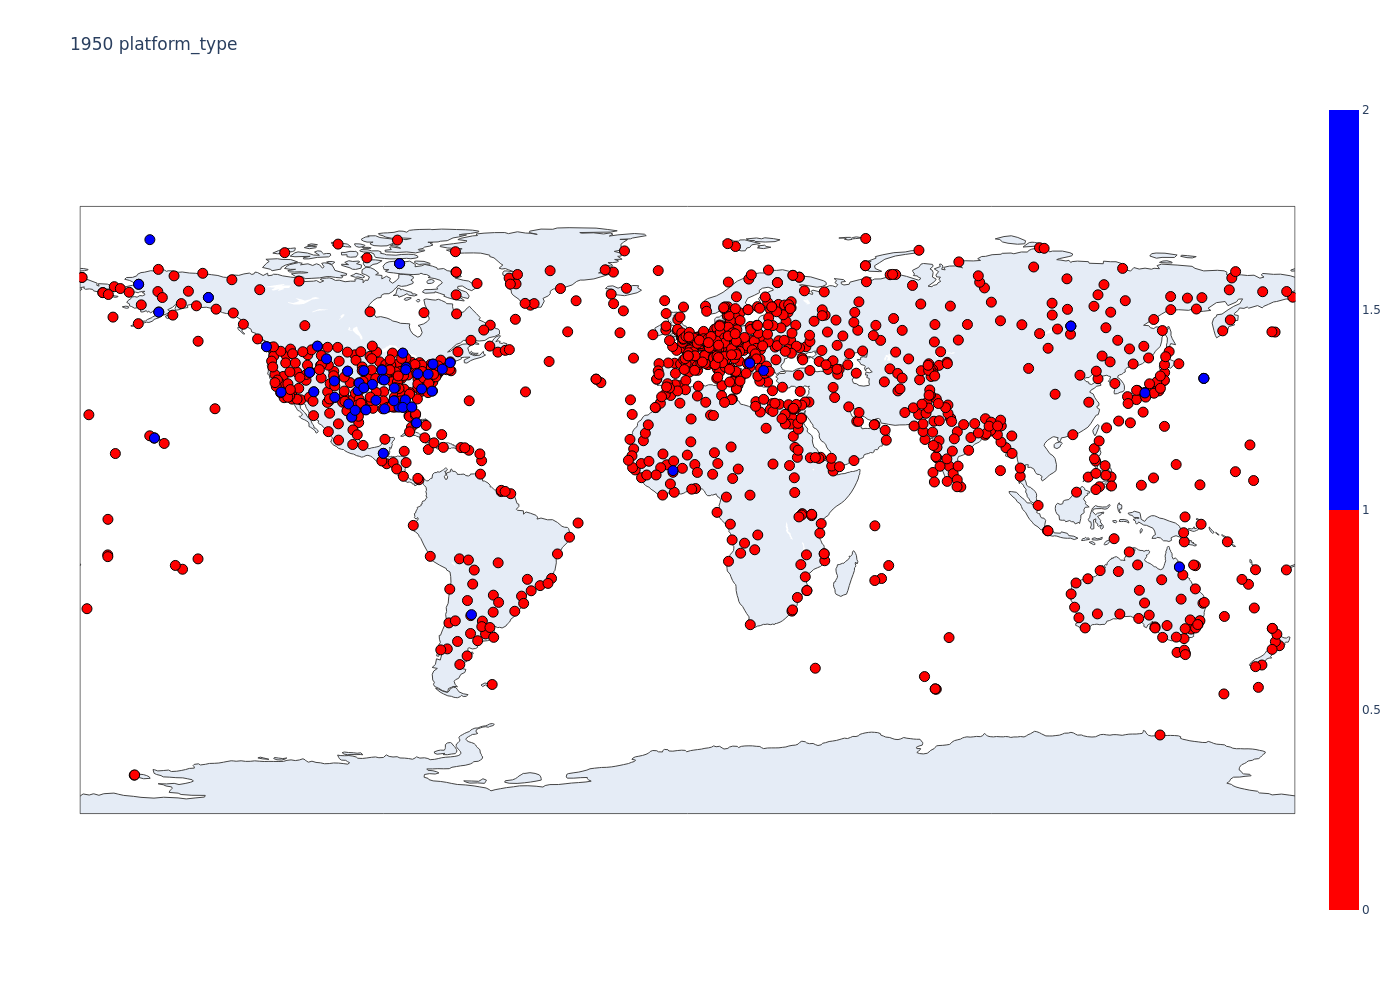

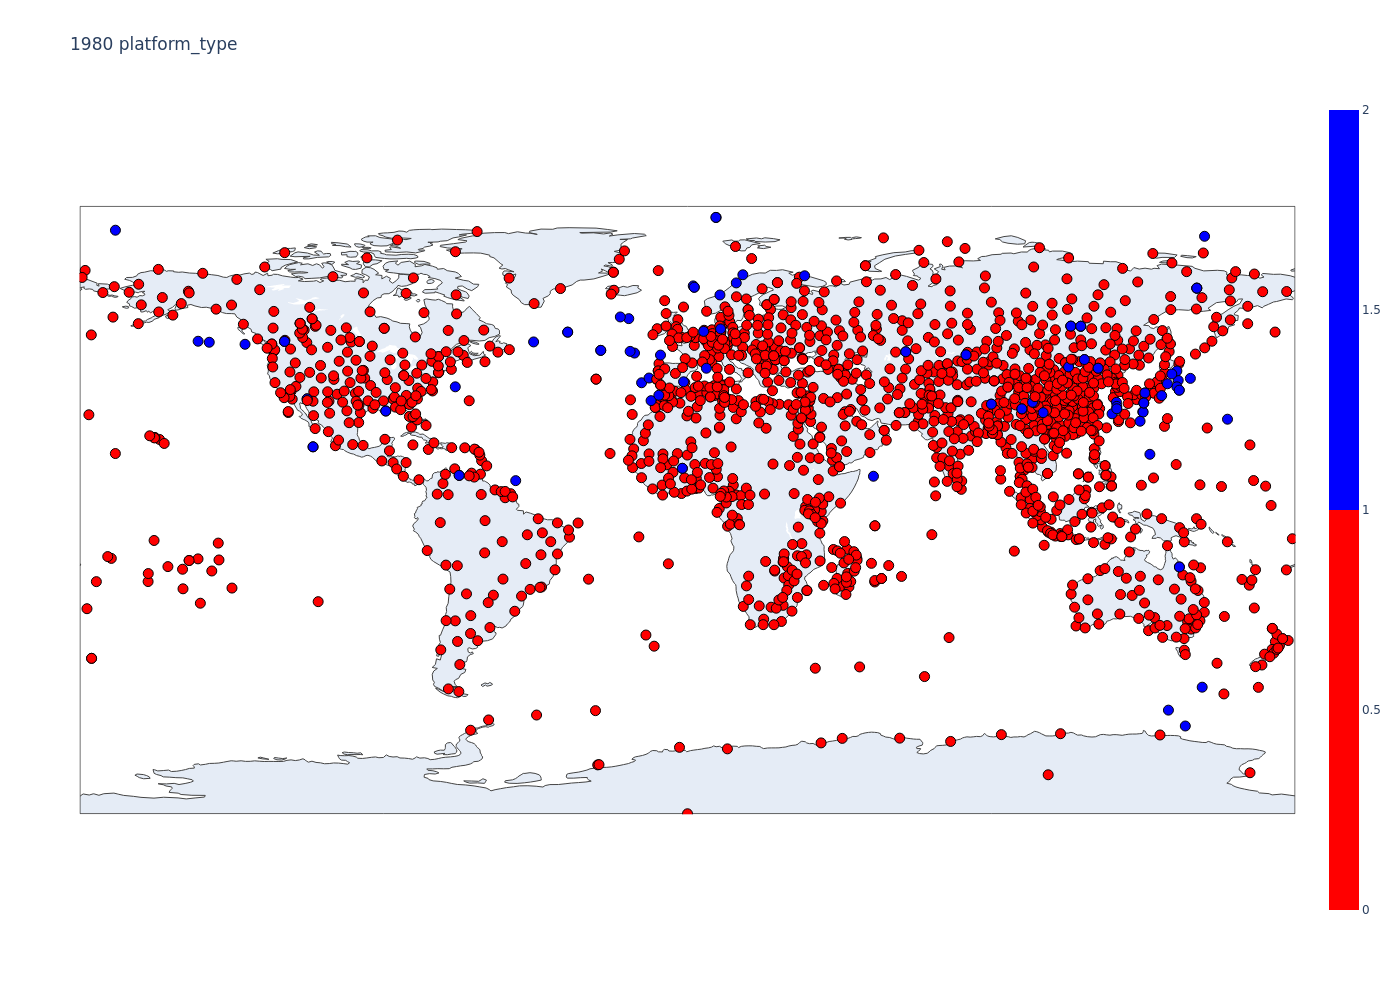

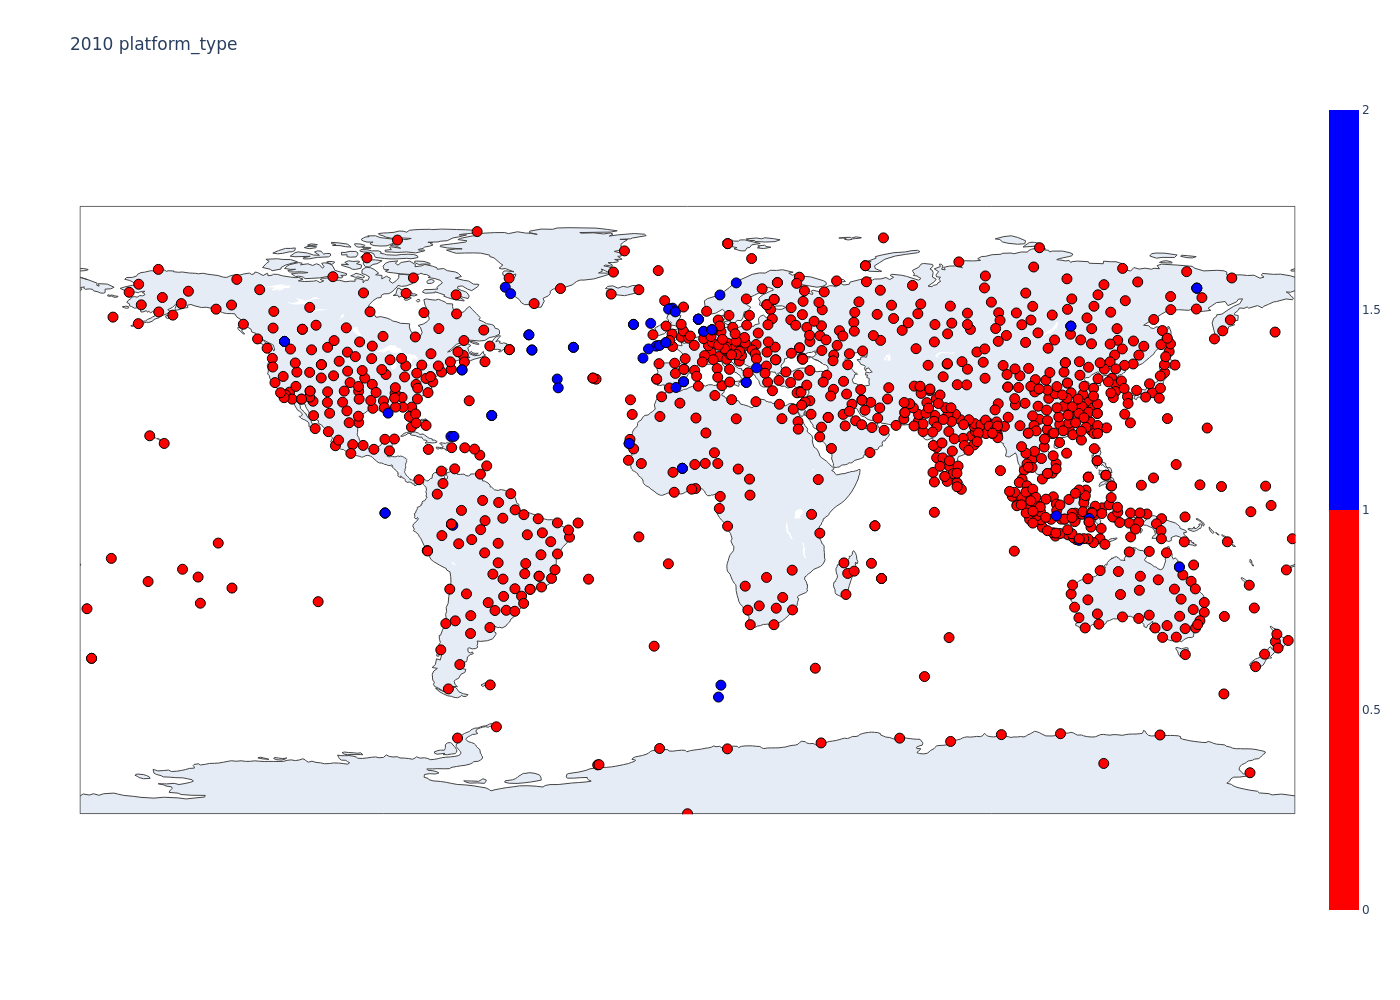

In [29]:
from IPython.display import Image
display(Image(filename='./world_map_plot_platform_type_1950-07-01.png'))
display(Image(filename='./world_map_plot_platform_type_1980-07-01.png'))
display(Image(filename='./world_map_plot_platform_type_2010-07-01.png'))
